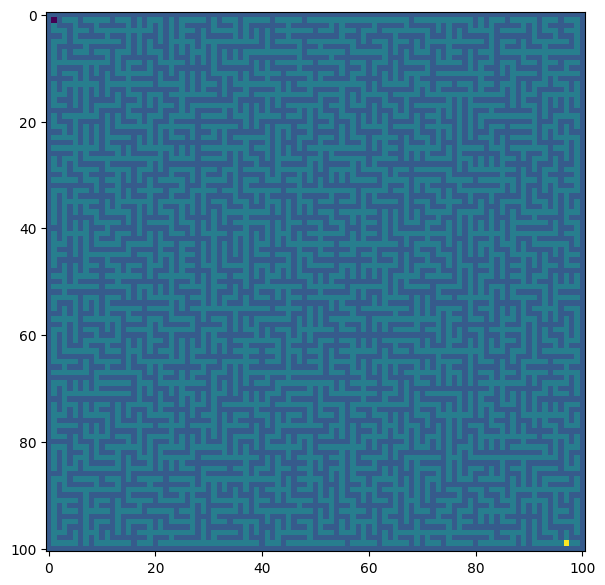

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def laberinto(m=101):
    if(m%2==0):
        m+=1
    plt.close('all')
    n=m
    Z=np.zeros((n,m))
    index={}
    pos=[]
    G=nx.Graph()
    for i in range(n):
        for j in range(m):
            if(i%2==1 and j%2==1):
                index[(i,j)]=len(pos)
                G.add_node(len(pos))
                pos.append((i,j))

    for i in range(n):
        for j in range(m):
            if(i%2==1 and j%2==1):
                #Conexiones desde el nodo i,j a todos los vecinos
                na=index[i,j]
                if((i+2,j) in index.keys()):
                    nc=index[i+2,j]
                    G.add_weighted_edges_from([(na, nc, np.random.rand()+1)])
                    #plt.plot([i,i+1,i+2],[j,j,j],'-k.')
                if((i,j+2) in index.keys()):
                    nc=index[i,j+2]
                    G.add_weighted_edges_from([(na, nc, np.random.rand()+1)])
                    #plt.plot([i,i,i],[j,j+1,j+2],'-k.')
    #plt.grid()
    #plt.figure()
    min_tree=nx.minimum_spanning_tree(G)
    d_org, d_dst=1e10, 1e10
    org=[-1,-1]
    dst=[-1,-1]
    for na, nb in min_tree.edges():
        ia,ja=pos[na]
        dist=((ia-len(Z))**2+(ja-len(Z))**2)
        if(dist<d_dst):
            d_dst=dist
            dst=[ia,ja]
        dist=((ia)**2+(ja)**2)
        if(dist<d_org):
            d_org=dist
            org=[ia,ja]
        Z[ia,ja]=1 #Parte caminable del laberinto
        ib,jb=pos[nb]
        Z[ib,jb]=1
        #plt.plot([ja,jb],[ia,ib],'-.k')
        ic=int((ia+ib)/2)
        jc=int((ja+jb)/2)
        Z[ic,jc]=1
    #plt.grid()
    #plt.figure()
    Z[org[0],org[1]]=-2
    Z[dst[0],dst[1]]=5

    #plt.imshow(Z)
    #plt.colorbar()
    return Z, org, dst

Z, org, dst=laberinto(101)
plt.figure(figsize=(7,7))
plt.imshow(Z)

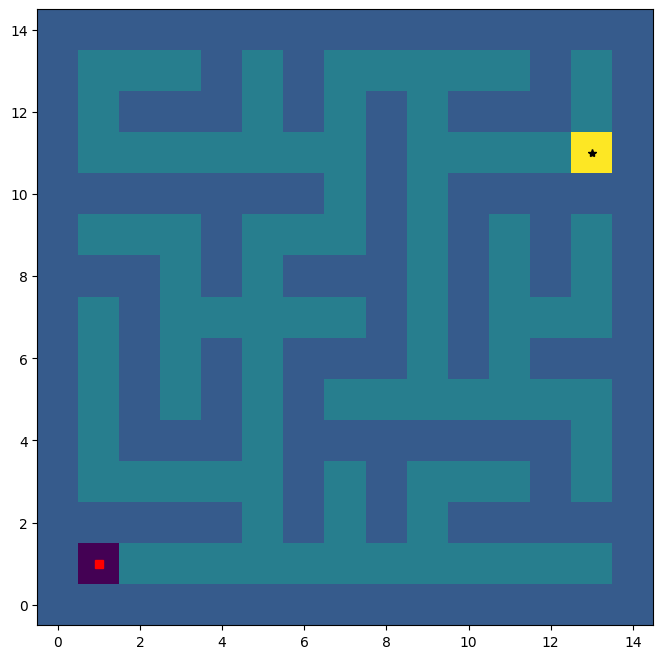

In [ ]:
#Set de acciones
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
class Maze:
  def __init__(self, shape=11):
    self.shape = shape
    self.Z, self.org, self.dst=laberinto(self.shape)
    nS = self.shape**2
    self.nA = 4
    self.nS=nS
    # Calculate transition probabilities
    P = {}
    for s in range(nS):
      position = np.unravel_index(s, (self.shape, self.shape), order='F')
      P[s] = { a : [] for a in range(self.nA) }
      P[s][UP] = self._calculate_transition_prob(position, [0,1])
      P[s][RIGHT] = self._calculate_transition_prob(position, [1,0])
      P[s][DOWN] = self._calculate_transition_prob(position, [0,-1])
      P[s][LEFT] = self._calculate_transition_prob(position, [-1,0])
    self.P=P
    # We always start in state (3, 0)
    isd = np.zeros(nS)
    suma=0
    for s in range(nS):
      position = np.unravel_index(s, (self.shape, self.shape), order='F')
      if(self.Z[position[0], position[1]]==1):
        isd[s]=1.0
        suma+=1
    #isd[np.ravel_multi_index(self.org, (self.shape, self.shape))] = suma
    isd=isd/np.sum(isd)
    self.isd=isd
    self.reset()
  def _limit_coordinates(self, coord):
    coord[0] = min(coord[0], self.shape - 1)
    coord[0] = max(coord[0], 0)
    coord[1] = min(coord[1], self.shape - 1)
    coord[1] = max(coord[1], 0)
    return coord

  def _calculate_transition_prob(self, current, delta):
    new_position = np.array(current) + np.array(delta)
    new_position = self._limit_coordinates(new_position).astype(int)
    reward=-10
    if(self.Z[new_position[0], new_position[1]]==0):
        reward=-100 #Porque llega a una pared
    new_state = np.ravel_multi_index(tuple(new_position), (self.shape, self.shape), order='F')
    is_done = tuple(new_position) == tuple(self.dst)
    if(is_done):
        reward=200
    return [(1.0, new_state, reward, is_done)]
  def reset(self):
    #self.s=np.ravel_multi_index(self.org, (self.shape, self.shape))
    st=np.random.choice(a=list(range(self.nS)), p=self.isd)
    self.s=st
    return self.s

  def step(self, action):
    _, next_state, reward, done=self.P[self.s][action][0]
    return next_state, reward, done, _

  def _render(self):
    plt.figure(figsize=(8,8))
    plt.imshow(self.Z.T, origin='lower') #Esto es fijo, no lo podemos cambiar.
    for s in range(self.nS):
      Si=np.unravel_index(s, (self.shape, self.shape), order='F')
      #plt.text(Si[0], Si[1], str(s))
    Start=self.org
    plt.plot(Start[0], Start[1], 'rs')
    End=self.dst
    plt.plot(End[0], End[1], 'k*')
    #plt.plot([0,1,2,3],[0,0,0,0],'or-')
    #plt.plot([0,0,0,0],[0,1,2,3],'og-')

ma=Maze(15)
ma._render()

In [ ]:
import matplotlib
import matplotlib.style

from collections import defaultdict
def pintar(Q, env):
  V=np.zeros((env.shape, env.shape))
  acc=np.zeros((env.shape, env.shape))-1
  for s,val in Q.items():
    #print(s,'->', sep='', end='')
    pos=np.unravel_index(s, (env.shape, env.shape), order='F')
    #print('z=',env.Z[pos[0], pos[1]], '; ', sep='', end='')
    if(env.Z[pos[0], pos[1]]!=0):
      V[pos[0], pos[1]]=np.max(val)
      acc[pos[0], pos[1]]=np.argmax(val)
    else:
      V[pos[0], pos[1]]=-1000
  plt.figure(figsize=(8,8))
  env._render()
  plt.figure()
  plt.imshow(V.T, origin='lower')#, alpha=.2)
  #plt.plot(env.org[1], env.org[0],'*m')
  #plt.plot(env.dst[1], env.dst[0],'sr')
  plt.title('Matriz v')
  plt.figure()
  env._render()
  dist=0.25
  for s in Q.keys():
    pos=np.unravel_index(s, (env.shape, env.shape), order='F')
    dx=0
    dy=0
    if(acc[pos[0], pos[1]]>=0):
      if(acc[pos[0], pos[1]]==UP):
        dy=+1
      if(acc[pos[0], pos[1]]==RIGHT):
        dx=1
      if(acc[pos[0], pos[1]]==DOWN):
        dy=-1
      if(acc[pos[0], pos[1]]==LEFT):
        dx=-1
      plt.arrow(pos[0], pos[1], dx*dist, dy*dist, color='r', head_width=0.35, width=0.05, overhang=1.0)
    #print(s, pos, acc[pos[0], pos[1]], dx, dy)
  #env.reset()
  #env.s=np.ravel_multi_index(env.org,(env.shape, env.shape), order='F')
  #if()
  #path=[env.s]
  #flag=True
  #while(flag):
  #print(V)


100%|██████████| 1000000/1000000 [20:38<00:00, 807.27it/s]


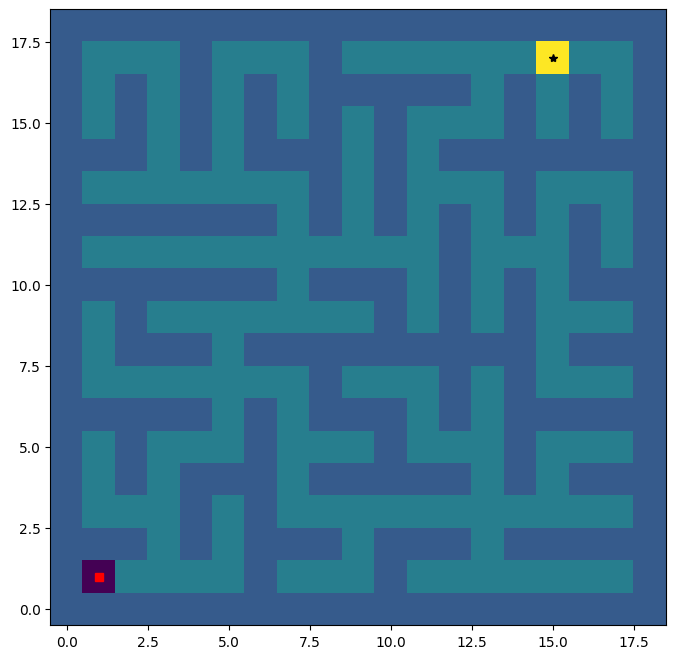

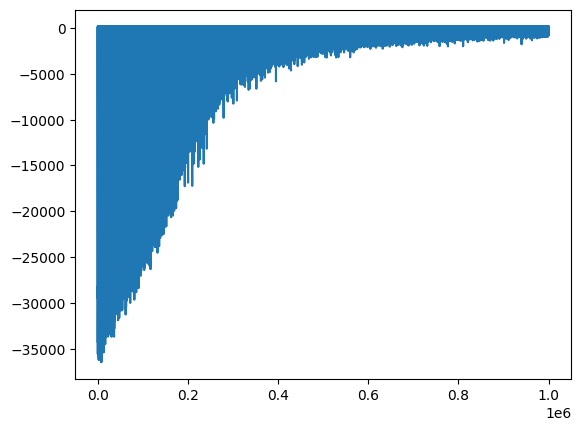

In [ ]:

from tqdm import tqdm
def qLearning(env, num_episodes, gamma=0.9, discount_factor = 0.9, alpha = 0.1, epsilon = 1):
  rwrds=[]
  eps=epsilon
  Q = defaultdict(lambda: np.random.rand(env.nA))
  for ith_episode in tqdm(range(num_episodes)):
    rw=0
    state = env.reset()
    eps*=discount_factor
    done=False
    cont=500
    stHst=[state]
    while(not(done) and cont>0):
      cont-=1
      if(np.random.rand()<eps): #Si se cumple, se aplica una política aleatoria
        action=np.random.choice([0,1,2,3])
      else:
        action=np.argmax(Q[state])
      next_state, reward, done, _ = env.step(action)
      rw+=reward
      best_next_action = np.argmax(Q[next_state])
      td_target = reward + gamma * Q[next_state][best_next_action]
      td_delta = td_target - Q[state][action]
      Q[state][action] += alpha * td_delta

      if(done):
        break
      state = next_state
      env.s=state
      stHst.append(state)
    #print(stHst)
    rwrds.append(rw)
  plt.figure()
  plt.plot(rwrds)
  return Q

env = Maze(19)
env._render()
num_episodes=1000000
K=np.power(0.1, 1/num_episodes)
Q = qLearning(env, num_episodes=num_episodes, gamma=0.9, discount_factor = K, alpha = 0.1, epsilon = 1)


<Figure size 800x800 with 0 Axes>

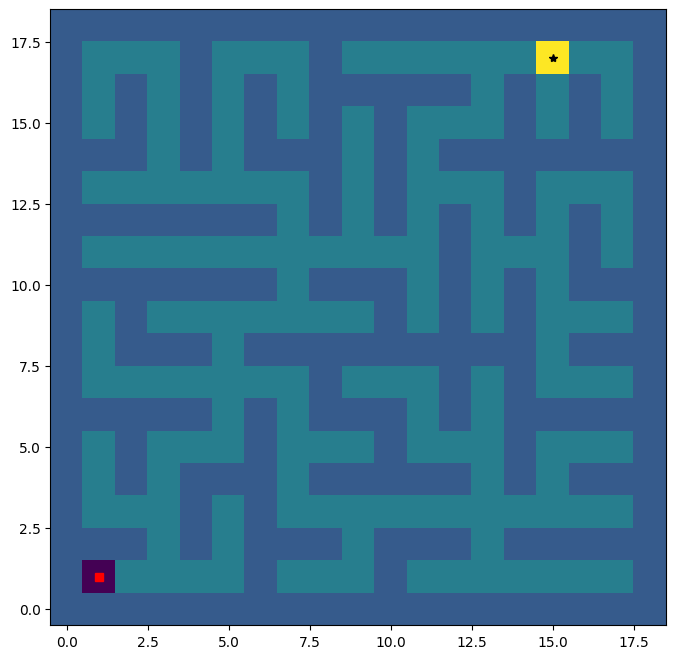

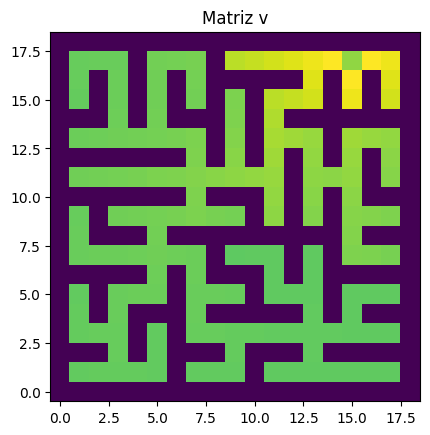

<Figure size 640x480 with 0 Axes>

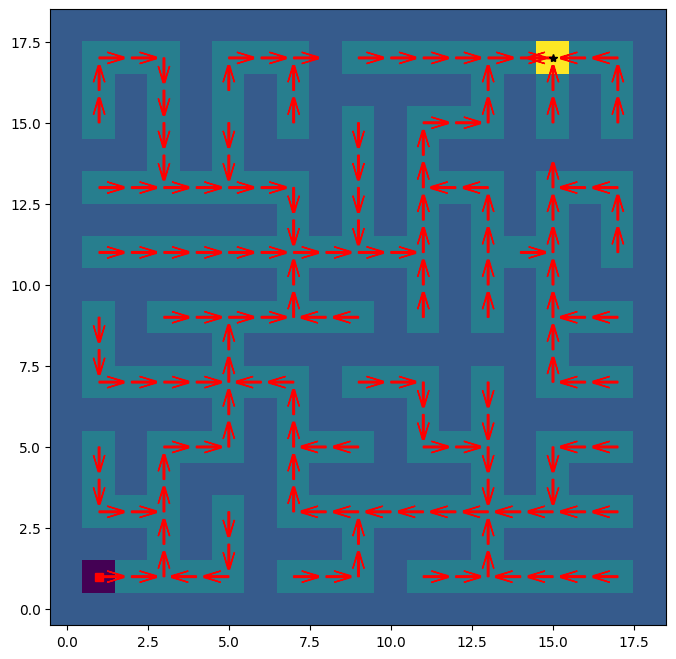

In [ ]:
pintar(Q,env)